In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


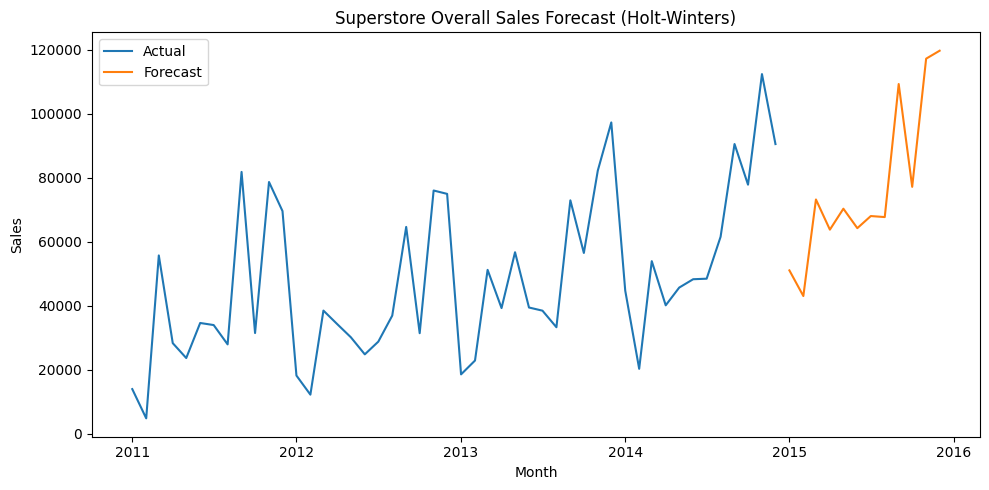

✅ Forecast complete!
Results saved to: superstore_overall_forecast.xlsx
Plot saved to: superstore_overall_forecast.png


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing

# ------------------------------
# 1. Load dataset
# ------------------------------
df=pd.read_excel('/kaggle/input/superstore1/Superstore.xlsx',sheet_name='Orders')

# ------------------------------
# 2. Aggregate monthly sales
# ------------------------------
df['OrderMonth'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()
monthly_sales = df.groupby('OrderMonth')['Sales'].sum().asfreq('MS') #MONTH START / the index will be set to the first day of each month.
monthly_sales = monthly_sales.fillna(0.0)

# ------------------------------
# 3. Fit forecasting model
# ------------------------------
n_obs = len(monthly_sales)
horizon = 12  # forecast 12 months ahead

try:
    if n_obs >= 24:
        model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12)
        fit = model.fit(optimized=True)
        model_name = "Holt-Winters"
    elif n_obs >= 6:
        model = Holt(monthly_sales)
        fit = model.fit(optimized=True)
        model_name = "Holt-Trend"
    else:
        model = SimpleExpSmoothing(monthly_sales)
        fit = model.fit(optimized=True)
        model_name = "SimpleExpSmoothing"

    forecast = fit.forecast(horizon)

except Exception as e:
    # fallback: repeat last observed value
    forecast = pd.Series([monthly_sales.iloc[-1]] * horizon,
                         index=pd.date_range(monthly_sales.index.max() + pd.offsets.MonthBegin(1),
                                             periods=horizon, freq='MS'))
    model_name = f"Naive ({e})"

# ------------------------------
# 4. Save and visualize results
# ------------------------------
forecast_df = forecast.reset_index() #Converts the Series into a DataFrame by moving the index (dates) into a normal column.
forecast_df.columns = ['ForecastDate', 'ForecastSales']
forecast_df.to_excel("superstore_overall_forecast.xlsx", index=False)
# Save as CSV
forecast_df.to_excel("/kaggle/working/Superstore_predicted2.xlsx", index=False)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales.index, monthly_sales.values, label="Actual")
plt.plot(forecast.index, forecast.values, label="Forecast")
plt.title(f"Superstore Overall Sales Forecast ({model_name})")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.savefig("superstore_overall_forecast.png")
plt.show()

print("✅ Forecast complete!")
print("Results saved to: superstore_overall_forecast.xlsx")
print("Plot saved to: superstore_overall_forecast.png")
